In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [97]:
from sympy import sqrt, cos, sin,  cosh,  sinh, Add
from sympy import Symbol, S, oo, Rational, Function, pi , factorial, O, symbols, lambdify, I
from sympy import Derivative, series, limit, Matrix, simplify, collect, solve, Poly, poly, diff, nsolve, transpose, factor_terms
from sympy import latex, init_printing
from sympy.core.numbers import NegativeOne, One, Zero
from sympy.printing.latex import print_latex

import numpy as np
from tqdm import tqdm
import ray

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, GenerateNDimCoordinateGrid
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import HamDrift6D, HamQuad6D
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.LieMaps.Poisson import PoissonBracket
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.Utils.Plotting import multi_countour_plot
from acchamiltoniansandmatrices.Factorization.Factorization import truncate, taylorize, dragt_finn_factorization
from acchamiltoniansandmatrices.Utils.Polynomials import getpoly, RotationMatrix2D, explicitCheck, geteigenvects
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import RnpQuad6DChroma
from acchamiltoniansandmatrices.Matrices.SymbMatrices import RsymbQuad6DChroma

# Initialization - run once

In [3]:
%matplotlib notebook
init_printing() 
ray.init()

2021-03-17 22:33:28,028	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.0.38',
 'raylet_ip_address': '192.168.0.38',
 'redis_address': '192.168.0.38:53113',
 'object_store_address': '/tmp/ray/session_2021-03-17_22-33-26_613429_10596/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-03-17_22-33-26_613429_10596/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-03-17_22-33-26_613429_10596',
 'metrics_export_port': 46523,
 'node_id': '6dbcb440e390213d072d86c92dd8e7c7df1add4d14c82440ee33ed2a'}

# Symbolis and symbolic replacement lists

## Symbols

In [98]:
x, px, y, py, z, delta = symbols('x p_x y p_y z delta', real=True)
eps, h , k0, k1, k2, sigma, betag = symbols('epsilon h k_0 k_1 k_2 sigma beta_gamma', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)

# redefine for use in ringham - otherwise assumption errors
LQF   = symbols("L_{QF}")
LQD   = symbols("L_{QD}")
LD    = symbols("L_D")
LD2   = symbols("L_{D2}")
KQF   = symbols("K_{QF}")
KQD   = symbols("K_{QD}")
dld   = symbols('\delta{L_D}') # delta length drift

## Replacements

In [99]:
# standardized substitutions that are useful - ORDER IN LISTS COUNTS !!!!
betagamma_rep = list(zip([beta0 * gamma0, beta0],[oo,1]))
series_rep    = list(zip([px,py,delta],[eps*px,eps*py,eps*delta]))
coord_rep     = list(zip([x,y],[eps*x,eps*y]))
thin_rep      = list(zip([px,py,delta],[0,0,0]))
xpx_rep       = list(zip([y,py,delta],[0,0,0]))
eps_rep       = list(zip([x,y,z,px,py,delta],[eps*x,eps*y,0,px*eps,py*eps,0]))
xyplane_rep   = list(zip([y,py,z,delta],[0,0,0,0]))

# Island settings for tracking

## Setup 1

In [100]:
#Island setting
_ld1 = 2.55
_ld2 = 2.35 #2.48
_lqf = 0.3
_lqd = 0.804
_k1  = 0.7
_k2  = - 0.35

repj = list(zip([LD,LD2,LQF,LQD,KQF,KQD,dld],[_ld1,_ld2,_lqf,_lqd,_k1,_k2,0]))

## Setup 2

In [101]:
#Island setting
_ld1 = 3.5805
_ld2 = 3.5805
_lqf = 0.342
_lqd = 0.668
_k1  = 0.49
_k2  = - 0.4999

rept = list(zip([LD,LD2,LQF,LQD,KQF,KQD,dld],[_ld1,_ld2,_lqf,_lqd,_k1,_k2,0]))

# Beam line definition

In [102]:
eldict = { 'drift' : 1, 'quad'  : 2, 'squad' : 25, 'sext'  : 3}

beamlines = [
    [eldict['quad'] , 4, LQF, KQF, 0],
    [eldict['drift'], 4, LD , Zero(), 0   ],
    [eldict['quad'] , 4, LQD, KQD, 0],
    [eldict['drift'], 4, LD , Zero(), 0   ],
    [eldict['quad'] , 4, LQF, KQF, 0],
]

# Functions

In [103]:
def gen(Ham, ox,opx,o, start=True):
    
    lox0  = LieOperator(Ham.subs(xyplane_rep),[x],[px])
    lopx0 = LieOperator(Ham.subs(xyplane_rep),[x],[px])

   
    
    def m(k):
        return (lox0*k).doit().expand()

    def n(k):
        return (lopx0*k).doit().expand()
    
    if start:
        xop   = LieOperator(x,[x],[px])
        pxop  = LieOperator(px,[x],[px])
        xopl  = list(nestList(m,xop,o))
        pxopl = list(nestList(n,pxop,o))
        
    else:
        xopl  = list(nestList(m,ox,o+1))[1:]
        pxopl = list(nestList(n,opx,o+1))[1:]
        
    return xopl, pxopl

def red(xopl, pxopl):
    eqs = [Rational(1,factorial(i)) * l.ham  if i!=0 else l.ham for i,l in tqdm(enumerate(xopl))]
    xops =sum(eqs)
    
    peqs = [Rational(1,factorial(i)) * l.ham if i!=0 else l.ham for i,l in tqdm(enumerate(pxopl))]
    pxops =sum(peqs)
    
    return xops, pxops



p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2
p_x**2 + x**2


13it [00:00, 19314.90it/s]
13it [00:00, 79483.90it/s]


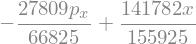

In [104]:
red(*gen(x**2+px**2,None,None,12))[1]

In [38]:
_op_osc = LieOperator(x**2+px**2,[x],[px])

In [78]:
_op_osc.LieMap(px,12).ham

100%|██████████| 11/11 [00:00<00:00, 291.92it/s]


In [80]:
LieOperator(x, [x],[px])